In [87]:
# Re-import necessary libraries after execution reset
import pandas as pd

# Reload the dataset
df = pd.read_csv('/Users/talhakimi/data-science-flights-project/Data/Cleaned_AllFlightsDataFinal.csv')

def remove_outliers_tukey(df, column="Price", groupby_cols=["Origin", "Destination"]):
    cleaned_list = []
    for _, group in df.groupby(groupby_cols):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (group[column] >= lower_bound) & (group[column] <= upper_bound)
        cleaned_list.append(group[mask])  

    return pd.concat(cleaned_list, ignore_index=True)  

df_cleaned = remove_outliers_tukey(df)

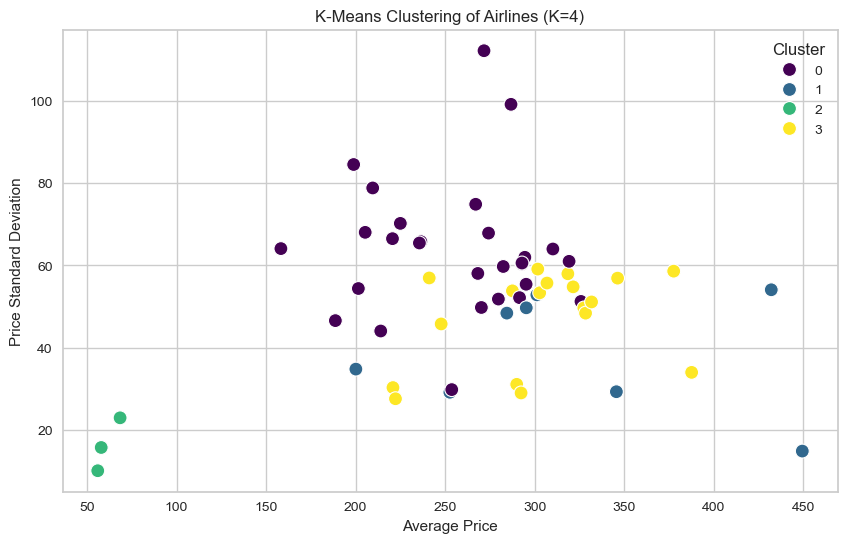

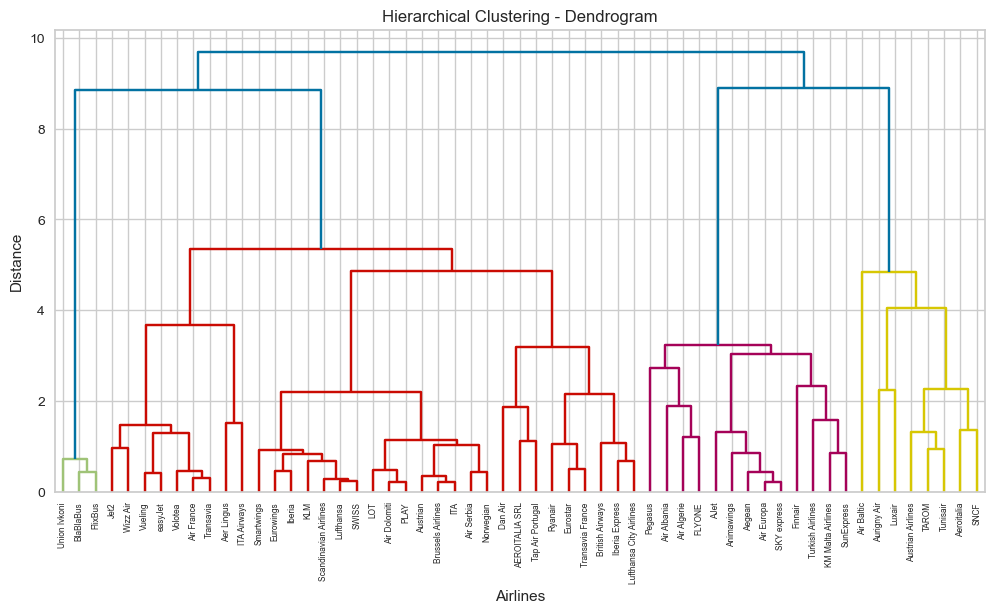


📊 **Cluster Insights:**
          avg_price  price_variability   min_price   max_price  \
Cluster                                                          
0        256.110548          63.512081  158.296228  325.887538   
1        320.152698          39.117565  200.165680  449.500000   
2         60.801798          16.216541   56.000000   68.476190   
3        302.952171          47.432580  220.880952  387.696379   

         airlines_in_cluster  
Cluster                       
0                         28  
1                          8  
2                          3  
3                         18  

✅ קובץ עם הקלאסטרים נשמר בשם: Airline_Clusters_KMeans.csv


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 🔹 1. חישוב נתונים מצטברים לכל חברת תעופה
airline_stats = df.groupby("Airline").agg({
    "Price": ["mean", "std"],      # מחיר ממוצע וסטיית תקן
    "Duration": "mean",             # זמן טיסה ממוצע
    "Stops": "mean"                 # מספר חניות ממוצע
}).reset_index()

# שינוי שם העמודות
airline_stats.columns = ["Airline", "avg_price", "std_price", "avg_duration", "avg_stops"]

# 🔹 2. נרמול הנתונים המספריים
scaler = StandardScaler()
scaled_features = scaler.fit_transform(airline_stats.iloc[:, 1:])  

# 🔹 3. קביעת מספר הקלאסטרים האופטימלי באמצעות מדד הסילואטה
silhouette_scores = []
k_range = range(2, 6)  # נבדוק בין 2 ל-5 אשכולות

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# 🔹 4. מציאת מספר האשכולות הטוב ביותר
best_k = k_range[np.argmax(silhouette_scores)]

# 🔹 5. הרצת K-Means עם מספר האשכולות האופטימלי
kmeans_optimal = KMeans(n_clusters=best_k, random_state=42, n_init=10)
airline_stats["Cluster"] = kmeans_optimal.fit_predict(scaled_features)

# 🔹 6. יצירת גרף להצגת הקלאסטרים
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=airline_stats["avg_price"], 
    y=airline_stats["std_price"], 
    hue=airline_stats["Cluster"], 
    palette="viridis",
    s=100
)
plt.title(f"K-Means Clustering of Airlines (K={best_k})")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=airline_stats["Airline"].values, leaf_rotation=90)
plt.title("Hierarchical Clustering - Dendrogram")
plt.xlabel("Airlines")
plt.ylabel("Distance")
plt.show()


# 🔹 7. הצגת ממוצעים לפי אשכול
cluster_insights = airline_stats.groupby("Cluster").agg(
    avg_price=("avg_price", "mean"),
    price_variability=("std_price", "mean"),
    min_price=("avg_price", "min"),
    max_price=("avg_price", "max"),
    airlines_in_cluster=("Cluster", "count")
)

# הצגת סיכום הקלאסטרים
print("\n📊 **Cluster Insights:**")
print(cluster_insights)

# 🔹 8. שמירת הנתונים עם הקלאסטרים החדשים לקובץ CSV
airline_stats.to_csv("Airline_Clusters_KMeans.csv", index=False)
print("\n✅ קובץ עם הקלאסטרים נשמר בשם: Airline_Clusters_KMeans.csv")


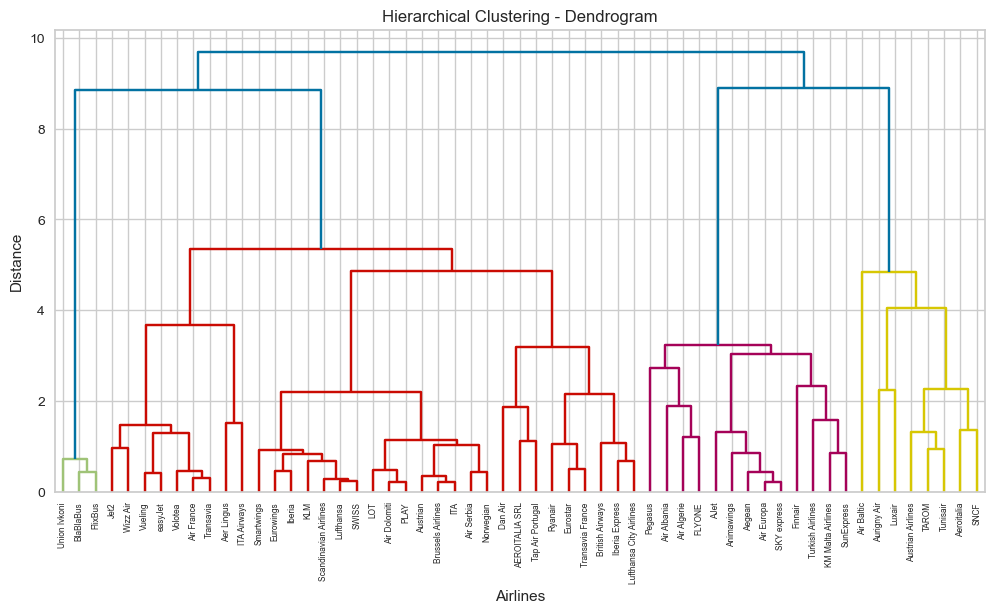


📊 Silhouette Score: 0.314


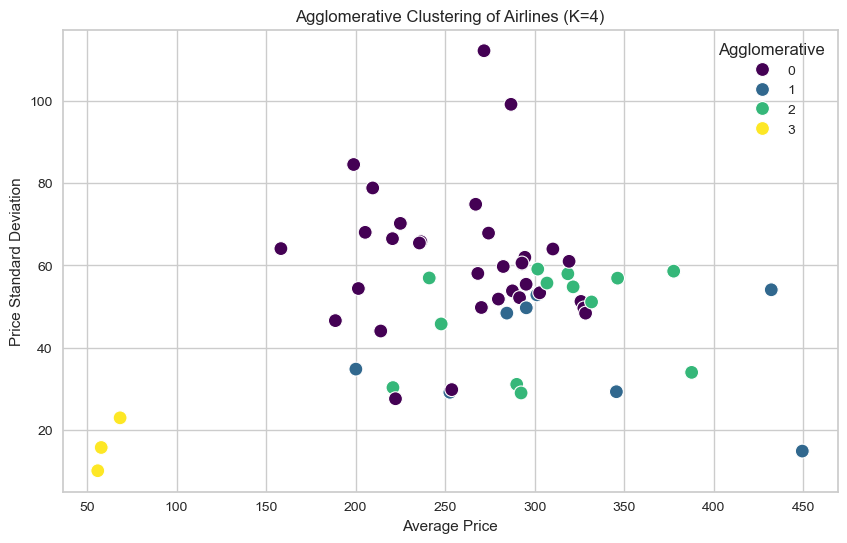


📊 **Cluster Insights:**
                avg_price  price_variability   min_price   max_price  \
Agglomerative                                                          
0              261.811228          60.940320  158.296228  328.455172   
1              320.152698          39.117565  200.165680  449.500000   
2              306.497223          47.776474  220.880952  387.696379   
3               60.801798          16.216541   56.000000   68.476190   

               airlines_in_cluster  
Agglomerative                       
0                               33  
1                                8  
2                               13  
3                                3  

✅ קובץ עם הקלאסטרים נשמר בשם: Airline_Clusters_Agglomerative.csv


In [89]:
#Agglomerative Clustering
linked = linkage(scaled_features, method="ward")  # קישוריות היררכית עם Ward method

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=airline_stats["Airline"].values, leaf_rotation=90)
plt.title("Hierarchical Clustering - Dendrogram")
plt.xlabel("Airlines")
plt.ylabel("Distance")
plt.show()

# 🔹 5. בחירת מספר האשכולות הטוב ביותר (לפי הדנדרוגרמה)
optimal_clusters = 4  # ניתן לשנות בהתאם לדנדרוגרמה

# 🔹 6. הרצת Agglomerative Clustering עם מספר האשכולות שנבחר
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, linkage="ward")
airline_stats["Agglomerative"] = agglo.fit_predict(scaled_features)

# 🔹 7. חישוב מדד סילואטה כדי לבדוק את איכות האשכולות
silhouette_avg = silhouette_score(scaled_features, airline_stats["Agglomerative"])
print(f"\n📊 Silhouette Score: {silhouette_avg:.3f}")

# 🔹 8. יצירת תרשים פיזור להמחשת הקלאסטרינג
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=airline_stats["avg_price"], 
    y=airline_stats["std_price"], 
    hue=airline_stats["Agglomerative"], 
    palette="viridis",
    s=100
)
plt.title(f"Agglomerative Clustering of Airlines (K={optimal_clusters})")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.show()

# 🔹 9. הצגת סיכום אשכולות
cluster_summary = airline_stats.groupby("Agglomerative").agg(
    avg_price=("avg_price", "mean"),
    price_variability=("std_price", "mean"),
    min_price=("avg_price", "min"),
    max_price=("avg_price", "max"),
    airlines_in_cluster=("Agglomerative", "count")
)

print("\n📊 **Cluster Insights:**")
print(cluster_summary)

# 🔹 10. שמירת הנתונים עם הקלאסטרים החדשים לקובץ CSV
airline_stats.to_csv("Airline_Clusters_Agglomerative.csv", index=False)
print("\n✅ קובץ עם הקלאסטרים נשמר בשם: Airline_Clusters_Agglomerative.csv")


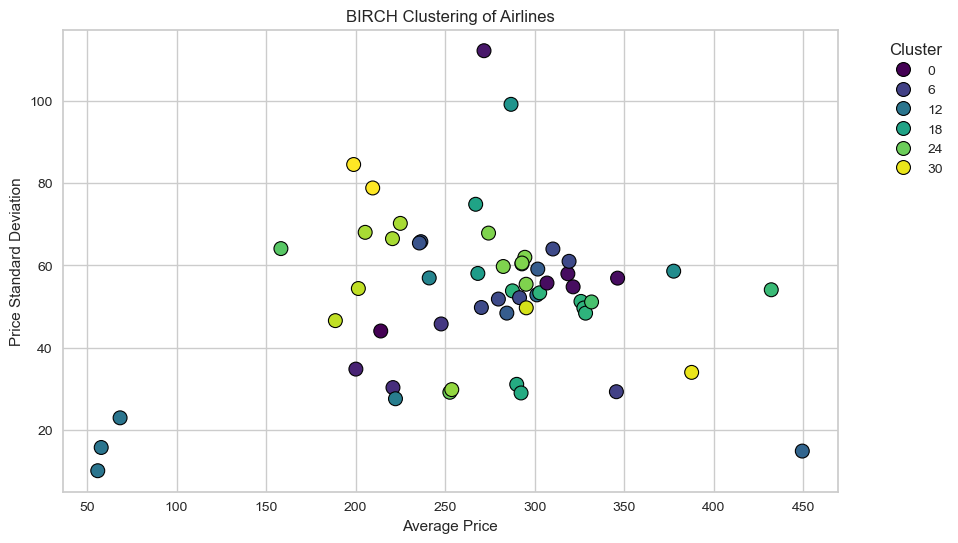

In [90]:
from sklearn.cluster import Birch

# 🔹 1. הרצת BIRCH עם סף (threshold) שמונע יצירת אשכולות גדולים מדי
birch = Birch(n_clusters=None, threshold=0.5)  # threshold שולט על רמת הפיצול
airline_stats["Cluster_BIRCH"] = birch.fit_predict(scaled_features)

# 🔹 2. בדיקת חלוקת החברות לפי האשכולות החדשים
birch_cluster_summary = airline_stats.groupby("Cluster_BIRCH").agg(
    avg_price=("avg_price", "mean"),
    price_variability=("std_price", "mean"),
    min_price=("avg_price", "min"),
    max_price=("avg_price", "max"),
    airlines_in_cluster=("Cluster_BIRCH", "count")
)

# הצגת התוצאות של BIRCH
birch_cluster_summary
# 🔹 יצירת גרף פיזור עם עיגולים להמחשת הקלאסטרים של BIRCH

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=airline_stats["avg_price"], 
    y=airline_stats["std_price"], 
    hue=airline_stats["Cluster_BIRCH"], 
    palette="viridis",
    s=100,
    edgecolor="black"  # מוסיף קווי מתאר לעיגולים
)
plt.title("BIRCH Clustering of Airlines")
plt.xlabel("Average Price")
plt.ylabel("Price Standard Deviation")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')  # הצגת מקרא מחוץ לגרף
plt.show()


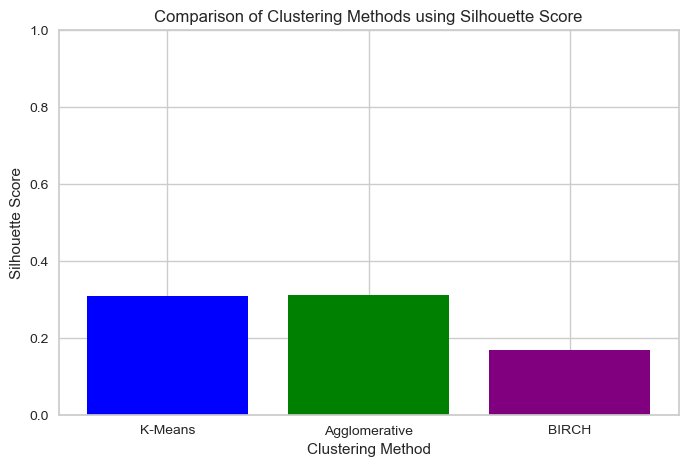

{'K-Means': 0.30905147728418025,
 'Agglomerative': 0.313708835075437,
 'BIRCH': 0.17064606710526695}

In [91]:
# 🔹 חישוב מדדי סילואטה לכל שיטה עם שמות העמודות המדויקים
silhouette_scores = {
    "K-Means": silhouette_score(scaled_features, airline_stats["Cluster"]),
    "Agglomerative": silhouette_score(scaled_features, airline_stats["Agglomerative"]),
    "BIRCH": silhouette_score(scaled_features, airline_stats["Cluster_BIRCH"])
}

# 🔹 יצירת גרף השוואתי למדדי הסילואטה של כל שיטה
plt.figure(figsize=(8,5))
plt.bar(silhouette_scores.keys(), silhouette_scores.values(), color=['blue', 'green', 'purple'])
plt.xlabel("Clustering Method")
plt.ylabel("Silhouette Score")
plt.title("Comparison of Clustering Methods using Silhouette Score")
plt.ylim(0, 1)  # טווח ערכים בין 0 ל-1 למדד הסילואטה
plt.show()

# הצגת נתוני הסילואטה כהשוואה
silhouette_scores
